In [13]:
import matplotlib
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt 
import scipy as sp
from scipy.sparse import linalg as ln
from scipy import sparse as sparse
import matplotlib.animation as animation


In [14]:
class Wave_Packet:
    def __init__(self, n_points, dt, sigma0=5.0, k0=1.0, x0=-150.0, x_begin=-200.0,
                 x_end=200.0, barrier_height=1.0, barrier_width=3.0):
 
        self.n_points = n_points
        self.sigma0 = sigma0
        self.k0 = k0
        self.x0 = x0
        self.dt = dt
        self.prob = np.zeros(n_points)
        self.barrier_width = barrier_width
        self.barrier_height = barrier_height
         
        """ 1) Space discretization """
        self.x, self.dx = np.linspace(x_begin, x_end, n_points, retstep=True)        
 
        """ 2) Initialization of the wave function to Gaussian wave packet """
        norm = (2.0 * np.pi * sigma0**2)**(-0.25)
        self.psi = np.exp(-(self.x - x0)**2 / (4.0 * sigma0**2))
        self.psi = self.psi.astype(np.complex128)
        self.psi *= np.exp(1.0j * k0 * self.x)
        self.psi *= (2.0 * np.pi * sigma0**2)**(-0.25)
        
        
        """ 3) Setting up the potential barrier """
        self.potential = np.array(
            [barrier_height if 0.0 < x < barrier_width else 0.0 for x in self.x])
 
        """ 4) Creating the Hamiltonian """
        h_diag = np.ones(n_points) / self.dx**2 + self.potential
        h_non_diag = np.ones(n_points - 1) * (-0.5 / self.dx**2)
        hamiltonian = sparse.diags([h_diag, h_non_diag, h_non_diag], [0, 1, -1])
         
        """ 5) Computing the Crank-Nicolson time evolution matrix """
        implicit = (sparse.eye(self.n_points) - dt / 2.0j * hamiltonian).tocsc()
        explicit = (sparse.eye(self.n_points) + dt / 2.0j * hamiltonian).tocsc() 
        self.evolution_matrix = ln.inv(implicit).dot(explicit).tocsr()

    def evolve(self):
        self.psi = self.evolution_matrix.dot(self.psi)
        self.prob = abs(self.psi)**2
 
        norm = sum(self.prob)
        self.prob /= norm
        self.psi /= norm**0.5
 
        return self.prob


In [15]:
class Animator:
    def __init__(self, wave_packet):
        self.time = 0.0
        self.wave_packet = wave_packet
        self.fig, self.ax = plt.subplots()
        plt.plot(self.wave_packet.x, self.wave_packet.potential * 0.1, color='r')
         
        self.time_text = self.ax.text(0.05, 0.95, '', horizontalalignment='left',
            verticalalignment='top', transform=self.ax.transAxes)
        self.line, = self.ax.plot(self.wave_packet.x, self.wave_packet.evolve())
        self.ax.set_ylim(0, 0.2)
        self.ax.set_xlabel('Position (a$_0$)')
        self.ax.set_ylabel('Probability density (a$_0$)')

    def update(self, data):
        self.line.set_ydata(data)
        return self.line,
     
    def time_step(self):
        while True:
            self.time += self.wave_packet.dt
            self.time_text.set_text(
                'Elapsed time: {:6.2f} fs'.format(self.time * 2.419e-2))
           
            yield self.wave_packet.evolve()
     
    def animate(self):
        self.ani = animation.FuncAnimation(
            self.fig, self.update, self.time_step, interval=5, blit=False)
        HTML(self.ani.to_html5_video())


C:\Users\Admin\AppData\Local\Temp\ipykernel_7784\1566118064.py:28: UserWarning: frames=<bound method Animator.time_step of <__main__.Animator object at 0x00000282550150D0>> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  self.ani = animation.FuncAnimation(


KeyboardInterrupt: 

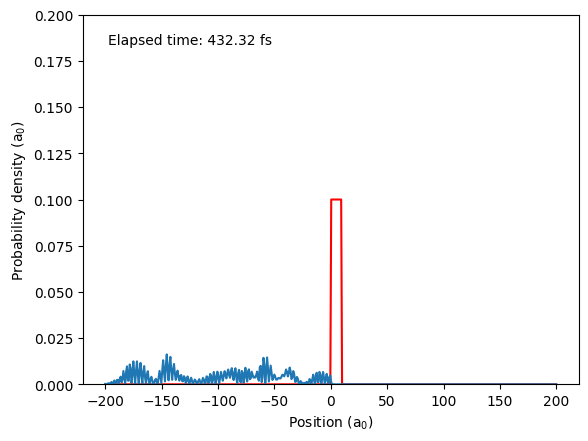

In [16]:
wave_packet = Wave_Packet(n_points=500, dt=0.5, barrier_width=10, barrier_height=1)
animator = Animator(wave_packet)
animator.animate()
plt.show()
